# Testing Markov and semi-Markov generation

In [1]:
import numpy as np
import seaborn as sns
import time
import timeit

from tqdm.notebook import tqdm
from types import SimpleNamespace
from typing import Sequence, Callable, Tuple

from bioslds.markov import SemiMarkov
from bioslds.plotting import FigureManager
from bioslds.utils import rle_encode

### Some useful definitions

In [2]:
def normalize_prob(v: np.ndarray):
    return v / np.sum(v)

## Pure Markov

Here we do not put any constraints on dwell time.

### Test statistics of initial state

In [3]:
rng = np.random.default_rng(4)
pure_ini = SimpleNamespace(n_components=5, n_samples=1000)
pure_ini.start_prob = normalize_prob(rng.uniform(size=pure_ini.n_components))
pure_ini.smm = SemiMarkov(pure_ini.n_components, start_prob=pure_ini.start_prob)

pure_ini.ini_states = np.zeros(pure_ini.n_samples, dtype=int)
for i in range(pure_ini.n_samples):
    crt_seq = pure_ini.smm.sample(1)
    pure_ini.ini_states[i] = crt_seq[0]

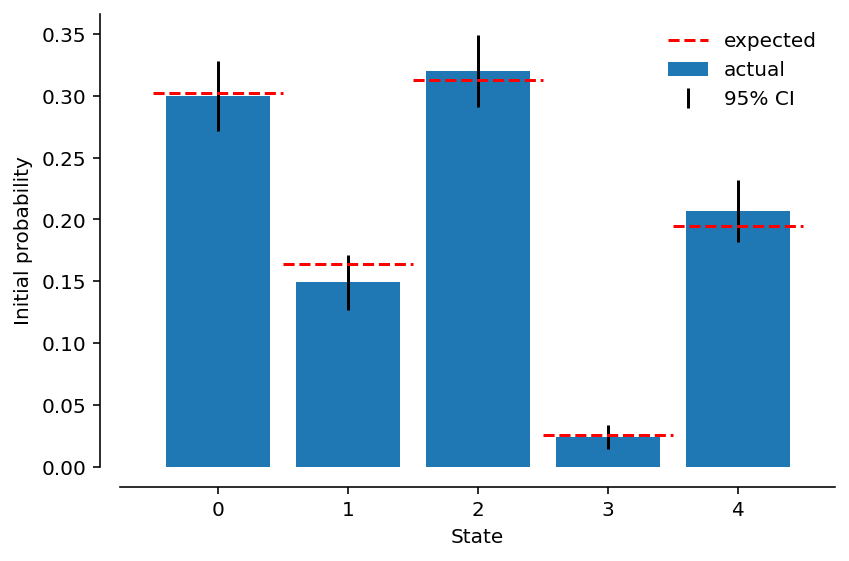

In [4]:
with FigureManager() as (_, ax):
    crt_heights, _, _ = ax.hist(
        pure_ini.ini_states,
        bins=np.arange(pure_ini.n_components + 1),
        rwidth=0.8,
        align="left",
        density=True,
        label="actual",
    )
    crt_error_estimates = np.sqrt(crt_heights * (1 - crt_heights) / pure_ini.n_samples)
    ax.errorbar(
        np.arange(pure_ini.n_components),
        crt_heights,
        1.96 * crt_error_estimates,
        label="95% CI",
        ls="none",
        c="k",
    )

    ax.plot(
        (np.arange(pure_ini.n_components)[:, None] + [-0.5, 0.5, np.nan]).ravel(),
        np.repeat(pure_ini.start_prob, 3),
        c="r",
        ls="--",
        label="expected",
    )
    ax.legend(frameon=False)

    ax.set_xticks(np.arange(pure_ini.n_components))
    ax.set_xlabel("State")
    ax.set_ylabel("Initial probability")

### Test transition statistics

In [5]:
rng = np.random.default_rng(5)
pure_trans = SimpleNamespace(n_components=4, n_samples=20000)
pure_trans.trans_mat = np.asarray(
    [
        normalize_prob(rng.uniform(size=pure_trans.n_components))
        for _ in range(pure_trans.n_components)
    ]
)
pure_trans.smm = SemiMarkov(
    pure_trans.n_components,
    trans_mat=pure_trans.trans_mat,
    dwell_times=1 / (1 - np.diag(pure_trans.trans_mat)),
)

crt_seq = pure_trans.smm.sample(pure_trans.n_samples + 1)
# encoding transitions as n_components * start_state + end_state
pure_trans.transitions = np.zeros(len(crt_seq), dtype=int)
for i in range(1, len(crt_seq)):
    crt_s1 = crt_seq[i - 1]
    crt_s2 = crt_seq[i]
    pure_trans.transitions[i] = crt_s1 * pure_trans.n_components + crt_s2

pure_trans.trans_mat_flat = pure_trans.trans_mat.ravel()

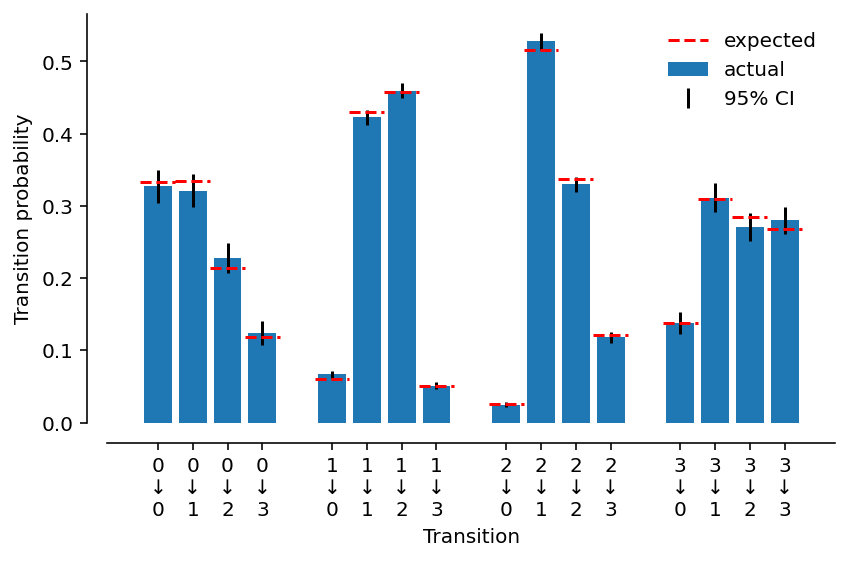

In [6]:
with FigureManager() as (_, ax):
    crt_x = np.hstack(
        [
            i * (pure_trans.n_components + 1) + np.arange(pure_trans.n_components)
            for i in range(pure_trans.n_components)
        ]
    )
    crt_heights = []
    crt_error_estimates = []
    for i in range(pure_trans.n_components):
        crt_low = i * pure_trans.n_components
        crt_high = crt_low + pure_trans.n_components
        crt_transitions = (
            pure_trans.transitions[
                (pure_trans.transitions >= crt_low)
                & (pure_trans.transitions < crt_high)
            ]
            - crt_low
        )
        crt_heights_each, _ = np.histogram(
            crt_transitions, bins=np.arange(pure_trans.n_components + 1), density=True,
        )
        crt_error_estimates_each = np.sqrt(
            crt_heights_each * (1 - crt_heights_each) / len(crt_transitions)
        )

        crt_heights.extend(crt_heights_each)
        crt_error_estimates.extend(crt_error_estimates_each)

    crt_heights = np.asarray(crt_heights)
    crt_error_estimates = np.asarray(crt_error_estimates)

    ax.bar(crt_x, crt_heights, label="actual")
    ax.errorbar(
        crt_x,
        crt_heights,
        1.96 * crt_error_estimates,
        label="95% CI",
        ls="none",
        c="k",
    )

    ax.plot(
        (crt_x[:, None] + [-0.5, 0.5, np.nan]).ravel(),
        np.repeat(pure_trans.trans_mat_flat, 3),
        c="r",
        ls="--",
        label="expected",
    )
    ax.legend(frameon=False)

    ax.set_xticks(crt_x)
    ax.set_xticklabels(
        [
            "{}\n↓\n{}".format(i // pure_trans.n_components, i % pure_trans.n_components)
            for i in range(pure_trans.n_components ** 2)
        ]
    )
    ax.set_xlabel("Transition")
    ax.set_ylabel("Transition probability")

### Test dwell time distribution

In [7]:
rng = np.random.default_rng(7)
pure_dwell = SimpleNamespace(n_components=3, n_samples=10000)
pure_dwell.trans_mat = np.asarray(
    [
        normalize_prob(rng.uniform(size=pure_dwell.n_components))
        for _ in range(pure_dwell.n_components)
    ]
)
pure_dwell.smm = SemiMarkov(
    pure_dwell.n_components,
    trans_mat=pure_dwell.trans_mat,
    dwell_times=1 / (1 - np.diag(pure_dwell.trans_mat)),
)

pure_dwell.seq = pure_dwell.smm.sample(pure_dwell.n_samples + 1)
pure_dwell.seq_rle = rle_encode(pure_dwell.seq)

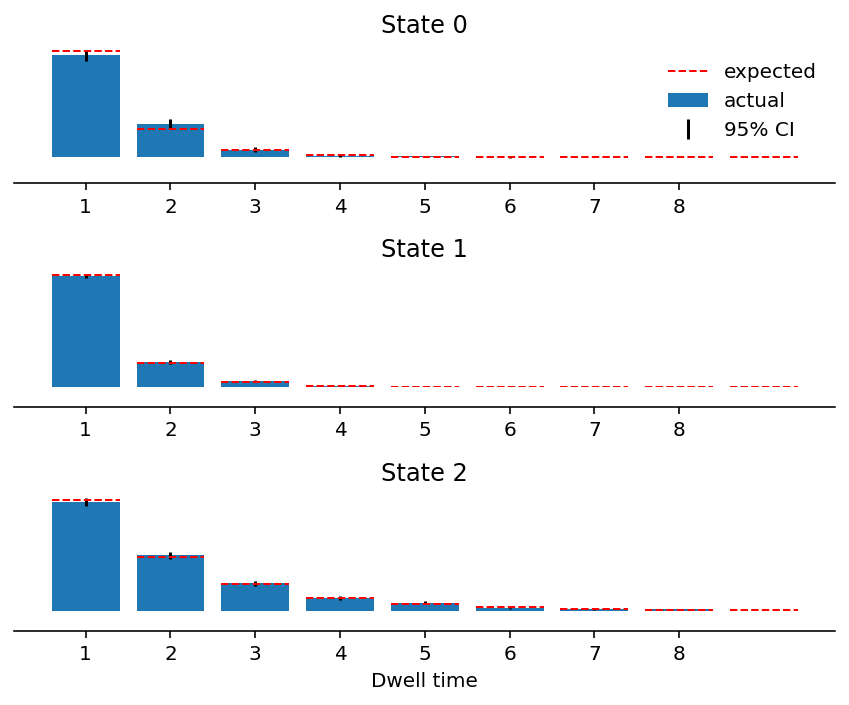

In [8]:
with FigureManager(
    pure_dwell.n_components, 1, figsize=(6, 5), despine_kws={"left": True}
) as (_, axs):
    crt_max_dwell = 9
    for i, ax in enumerate(axs):
        # last dwell time is truncated
        crt_dwell_times = [_[1] for _ in pure_dwell.seq_rle[:-1] if _[0] == i]
        crt_heights, _, _ = ax.hist(
            crt_dwell_times,
            bins=np.arange(1, crt_max_dwell + 1),
            rwidth=0.8,
            align="left",
            label="actual",
            density=True,
        )
        crt_error_estimates = np.sqrt(
            crt_heights * (1 - crt_heights) / len(crt_dwell_times)
        )
        ax.errorbar(
            np.arange(1, crt_max_dwell),
            crt_heights,
            1.96 * crt_error_estimates,
            label="95% CI",
            ls="none",
            c="k",
        )

        crt_stay_p = pure_dwell.trans_mat[i, i]
        crt_expected = crt_stay_p ** np.arange(crt_max_dwell) * (1 - crt_stay_p)
        ax.plot(
            (np.arange(1, crt_max_dwell + 1)[:, None] + [-0.4, 0.4, np.nan]).ravel(),
            np.repeat(crt_expected, 3),
            c="r",
            ls="--",
            lw=1.0,
            label="expected",
        )

        ax.set_title(f"State {i}")
        ax.set_xticks(np.arange(1, crt_max_dwell))
        ax.set_yticks([])

    axs[0].legend(frameon=False)
    axs[-1].set_xlabel("Dwell time")

## Semi-Markov

Checking that minimum and maximum constraints on the dwell times are obeyed.

### Test transition-to-new-state statistics

In [9]:
rng = np.random.default_rng(6)
semi_trans = SimpleNamespace(
    n_components=4, n_samples=20000, min_dwell=[2, 5, 0, 3], max_dwell=[3, 8, 4, np.inf]
)
# the diagonal elements aren't used
semi_trans.trans_mat = 0.4 * np.eye(semi_trans.n_components) + 0.6 * np.asarray(
    [
        normalize_prob(rng.uniform(size=semi_trans.n_components))
        for _ in range(semi_trans.n_components)
    ]
)
semi_trans.dwell_times = [2.5, 6.7, 2.0, 3.5]
semi_trans.smm = SemiMarkov(
    semi_trans.n_components,
    trans_mat=semi_trans.trans_mat,
    min_dwell=semi_trans.min_dwell,
    max_dwell=semi_trans.max_dwell,
    dwell_times=semi_trans.dwell_times,
)

semi_trans.seq = semi_trans.smm.sample(semi_trans.n_samples + 1)
semi_trans.seq_rle = rle_encode(semi_trans.seq)

# encoding transitions as n_components * start_state + end_state
semi_trans.transitions = np.zeros(len(semi_trans.seq_rle) - 1, dtype=int)
for i in range(1, len(semi_trans.seq_rle)):
    crt_s1 = semi_trans.seq_rle[i - 1][0]
    crt_s2 = semi_trans.seq_rle[i][0]
    semi_trans.transitions[i - 1] = crt_s1 * semi_trans.n_components + crt_s2

semi_trans.trans_mat_noauto = np.copy(semi_trans.trans_mat)
for i in range(semi_trans.n_components):
    semi_trans.trans_mat_noauto[i, i] = 0
    semi_trans.trans_mat_noauto[i] = normalize_prob(semi_trans.trans_mat_noauto[i])

semi_trans.trans_mat_flat = semi_trans.trans_mat.ravel()
semi_trans.trans_mat_noauto_flat = semi_trans.trans_mat_noauto.ravel()

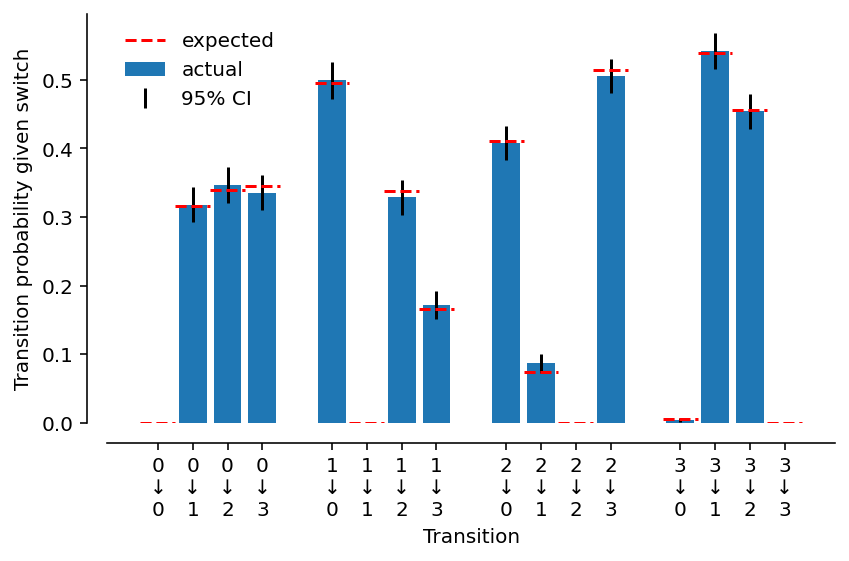

In [10]:
with FigureManager() as (_, ax):
    crt_x = np.hstack(
        [
            i * (semi_trans.n_components + 1) + np.arange(semi_trans.n_components)
            for i in range(semi_trans.n_components)
        ]
    )
    crt_heights = []
    crt_error_estimates = []
    for i in range(semi_trans.n_components):
        crt_low = i * semi_trans.n_components
        crt_high = crt_low + semi_trans.n_components
        crt_transitions = (
            semi_trans.transitions[
                (semi_trans.transitions >= crt_low)
                & (semi_trans.transitions < crt_high)
            ]
            - crt_low
        )
        crt_heights_each, _ = np.histogram(
            crt_transitions, bins=np.arange(pure_trans.n_components + 1), density=True,
        )
        crt_error_estimates_each = np.sqrt(
            crt_heights_each * (1 - crt_heights_each) / len(crt_transitions)
        )

        crt_heights.extend(crt_heights_each)
        crt_error_estimates.extend(crt_error_estimates_each)

    crt_heights = np.asarray(crt_heights)
    crt_error_estimates = np.asarray(crt_error_estimates)

    ax.bar(crt_x, crt_heights, label="actual")
    ax.errorbar(
        crt_x,
        crt_heights,
        1.96 * crt_error_estimates,
        label="95% CI",
        ls="none",
        c="k",
    )

    ax.plot(
        (crt_x[:, None] + [-0.5, 0.5, np.nan]).ravel(),
        np.repeat(semi_trans.trans_mat_noauto_flat, 3),
        c="r",
        ls="--",
        label="expected",
    )
    ax.legend(frameon=False)

    ax.set_xticks(crt_x)
    ax.set_xticklabels(
        [
            "{}\n↓\n{}".format(i // semi_trans.n_components, i % semi_trans.n_components)
            for i in range(semi_trans.n_components ** 2)
        ]
    )
    ax.set_xlabel("Transition")
    ax.set_ylabel("Transition probability given switch")

### Test dwell time distribution

Using the parameters and data from above.

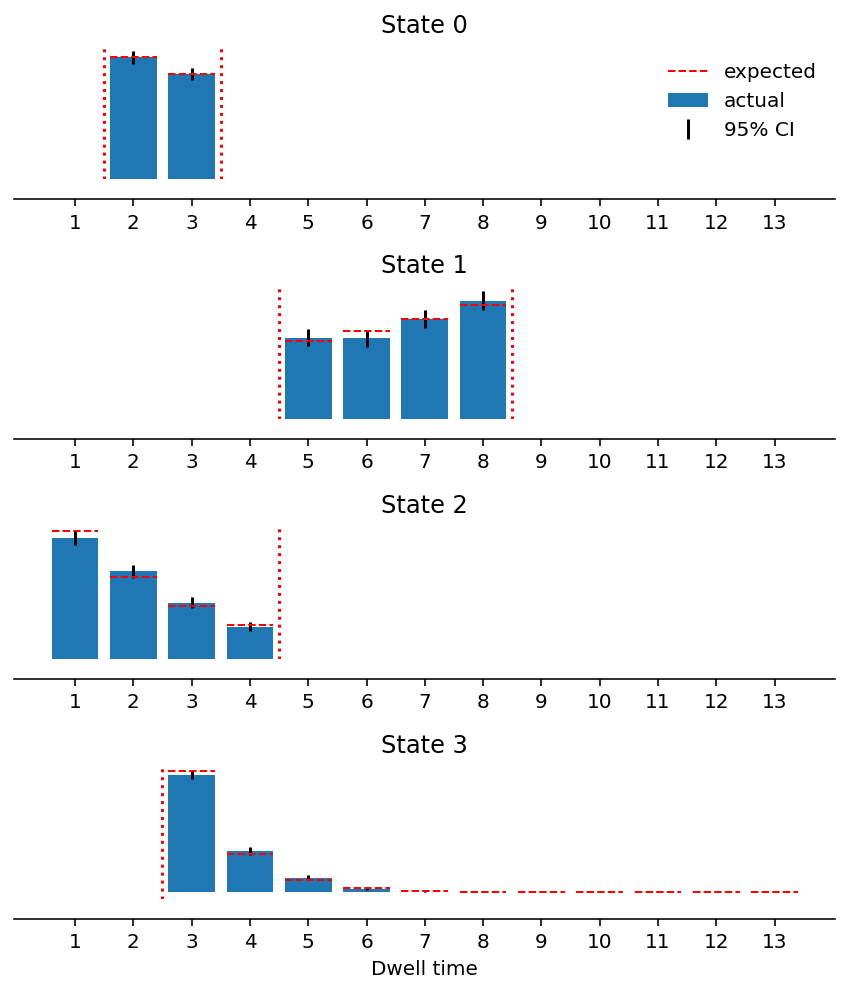

In [11]:
with FigureManager(
    semi_trans.n_components, 1, figsize=(6, 7), despine_kws={"left": True}
) as (_, axs):
    crt_max_dwell = 14
    for i, ax in enumerate(axs):
        # last dwell time is truncated
        crt_dwell_times = [_[1] for _ in semi_trans.seq_rle[:-1] if _[0] == i]
        crt_heights, _, _ = ax.hist(
            crt_dwell_times,
            bins=np.arange(1, crt_max_dwell + 1),
            rwidth=0.8,
            align="left",
            label="actual",
            density=True,
        )
        crt_error_estimates = np.sqrt(
            crt_heights * (1 - crt_heights) / len(crt_dwell_times)
        )
        ax.errorbar(
            np.arange(1, crt_max_dwell),
            crt_heights,
            1.96 * crt_error_estimates,
            label="95% CI",
            ls="none",
            c="k",
        )

        if semi_trans.min_dwell[i] > 0:
            ax.axvline(semi_trans.min_dwell[i] - 0.5, ls=":", c="r")
        if np.isfinite(semi_trans.max_dwell[i]):
            ax.axvline(semi_trans.max_dwell[i] + 0.5, ls=":", c="r")

        # fit with a truncated geometric distribution
        crt_stay_p = np.exp(np.mean(np.diff(np.log(crt_heights[crt_heights > 0]))))
        crt_expected = crt_stay_p ** np.arange(crt_max_dwell - 1) * (1 - crt_stay_p)
        # now impose constraints
        if semi_trans.min_dwell[i] > 1:
            crt_expected[: semi_trans.min_dwell[i] - 1] = np.nan
        if np.isfinite(semi_trans.max_dwell[i]):
            crt_expected[semi_trans.max_dwell[i] :] = np.nan
        
        # assuming we're capturing almost all of the probability mass
        crt_expected /= np.nansum(crt_expected)
        ax.plot(
            (np.arange(1, crt_max_dwell)[:, None] + [-0.4, 0.4, np.nan]).ravel(),
            np.repeat(crt_expected, 3),
            c="r",
            ls="--",
            lw=1.0,
            label="expected",
        )

        ax.set_title(f"State {i}")
        ax.set_xticks(np.arange(1, crt_max_dwell))
        ax.set_yticks([])

    axs[0].legend(frameon=False)
    axs[-1].set_xlabel("Dwell time")

### Test long dwell time

In [12]:
rng = np.random.default_rng(3)
semi_dwell = SimpleNamespace(
    n_components=3,
    min_dwell=50,
    max_dwell=150,
    n_samples=1000000,
    dwell_times=[66.7, 125.0, 100.0],
)
semi_dwell.trans_mat = rng.uniform(
    size=(semi_dwell.n_components, semi_dwell.n_components)
)

semi_dwell.smm = SemiMarkov(
    semi_dwell.n_components,
    trans_mat=semi_dwell.trans_mat,
    dwell_times=semi_dwell.dwell_times,
    min_dwell=semi_dwell.min_dwell,
    max_dwell=semi_dwell.max_dwell,
    rng=6,
)

t0 = time.time()
semi_dwell.seq = semi_dwell.smm.sample(semi_dwell.n_samples)
t1 = time.time()
print(f"Generating {semi_dwell.n_samples} samples took {t1 - t0:.2f} seconds.")

semi_dwell.seq_rle = rle_encode(semi_dwell.seq)

Generating 1000000 samples took 0.65 seconds.


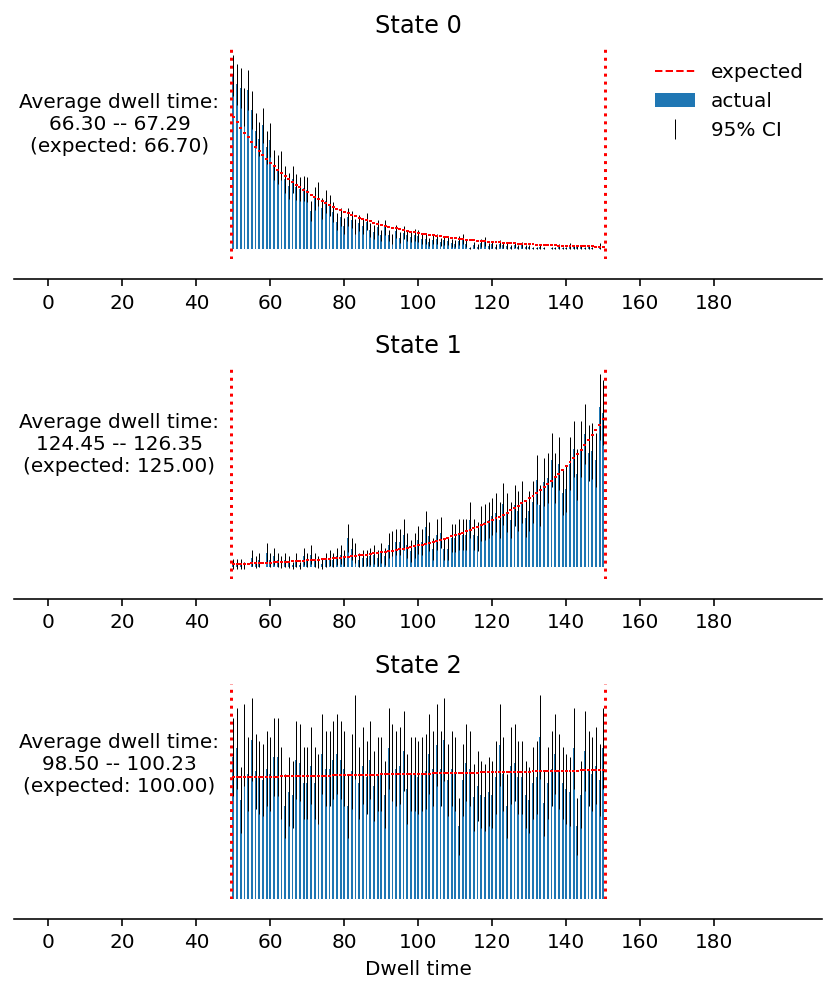

In [13]:
with FigureManager(
    semi_dwell.n_components, 1, figsize=(6, 7), despine_kws={"left": True}
) as (_, axs):
    crt_max_dwell = 200
    for i, ax in enumerate(axs):
        # last dwell time is truncated
        crt_dwell_times = [_[1] for _ in semi_dwell.seq_rle[:-1] if _[0] == i]
        crt_heights, _, _ = ax.hist(
            crt_dwell_times,
            bins=np.arange(1, crt_max_dwell + 1),
            rwidth=0.5,
            align="left",
            label="actual",
            density=True,
        )
        crt_error_estimates = np.sqrt(
            crt_heights * (1 - crt_heights) / len(crt_dwell_times)
        )
        ax.errorbar(
            np.arange(1, crt_max_dwell),
            crt_heights,
            1.96 * crt_error_estimates,
            label="95% CI",
            ls="none",
            c="k",
            lw=0.5,
        )

        ax.axvline(semi_dwell.min_dwell - 0.5, ls=":", c="r")
        ax.axvline(semi_dwell.max_dwell + 0.5, ls=":", c="r")

        # fit with a truncated geometric distribution
        crt_stay_p = np.exp(np.mean(np.diff(np.log(crt_heights[crt_heights > 0]))))
        crt_expected = crt_stay_p ** np.arange(crt_max_dwell) * (1 - crt_stay_p)
        # now impose constraints
        crt_expected[: semi_dwell.min_dwell - 1] = np.nan
        crt_expected[semi_dwell.max_dwell :] = np.nan

        # here we know we're capturing all the probability mass
        crt_expected /= np.nansum(crt_expected)
        ax.plot(
            (np.arange(1, crt_max_dwell + 1)[:, None] + [-0.4, 0.4, np.nan]).ravel(),
            np.repeat(crt_expected, 3),
            c="r",
            ls="--",
            lw=1.0,
            label="expected",
        )

        crt_avg = np.mean(crt_dwell_times)
        crt_sem = np.std(crt_dwell_times) / np.sqrt(len(crt_dwell_times))
        crt_exp_avg = semi_dwell.dwell_times[i]
        ax.annotate(
            f"Average dwell time:\n{crt_avg - 1.96 * crt_sem:.2f} "
            + f"-- {crt_avg + 1.96 * crt_sem:.2f}\n"
            + f"(expected: {crt_exp_avg:.2f})",
            xy=(0.13, 0.5),
            xycoords="axes fraction",
            horizontalalignment="center",
        )

        ax.set_title(f"State {i}")
        ax.set_xticks(np.arange(0, crt_max_dwell, 20))
        ax.set_yticks([])

    axs[0].legend(frameon=False)
    axs[-1].set_xlabel("Dwell time")

### Test average with no max dwell time

In [14]:
rng = np.random.default_rng(5)
semi_dwell_no_max = SimpleNamespace(
    n_components=2, min_dwell=30, n_samples=1000000, dwell_times=[40.0, 85.0]
)
semi_dwell_no_max.trans_mat = rng.uniform(
    size=(semi_dwell_no_max.n_components, semi_dwell_no_max.n_components)
)

semi_dwell_no_max.smm = SemiMarkov(
    semi_dwell_no_max.n_components,
    trans_mat=semi_dwell_no_max.trans_mat,
    dwell_times=semi_dwell_no_max.dwell_times,
    min_dwell=semi_dwell_no_max.min_dwell,
    rng=5,
)

t0 = time.time()
semi_dwell_no_max.seq = semi_dwell_no_max.smm.sample(semi_dwell_no_max.n_samples)
t1 = time.time()
print(f"Generating {semi_dwell_no_max.n_samples} samples took {t1 - t0:.2f} seconds.")

semi_dwell_no_max.seq_rle = rle_encode(semi_dwell_no_max.seq)

Generating 1000000 samples took 0.03 seconds.


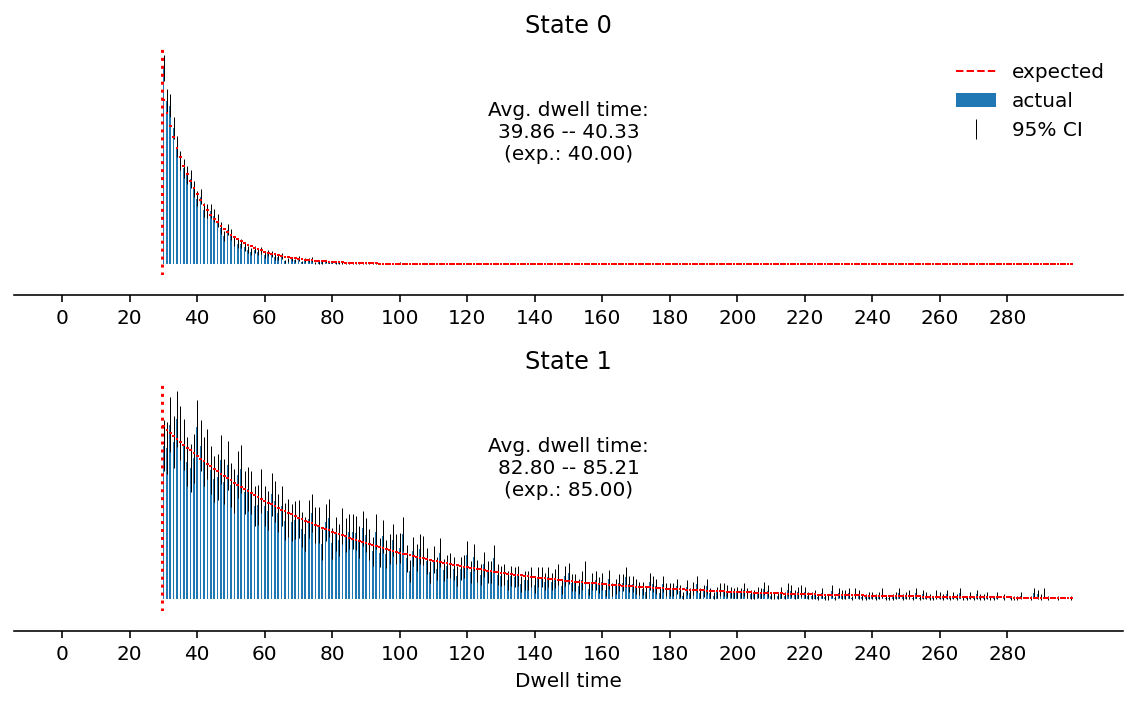

In [15]:
with FigureManager(
    semi_dwell_no_max.n_components, 1, figsize=(8, 5), despine_kws={"left": True}
) as (_, axs):
    crt_max_dwell = 300
    for i, ax in enumerate(axs):
        # last dwell time is truncated
        crt_dwell_times = [_[1] for _ in semi_dwell_no_max.seq_rle[:-1] if _[0] == i]
        crt_heights, _, _ = ax.hist(
            crt_dwell_times,
            bins=np.arange(1, crt_max_dwell + 1),
            rwidth=0.5,
            align="left",
            label="actual",
            density=True,
        )
        crt_error_estimates = np.sqrt(
            crt_heights * (1 - crt_heights) / len(crt_dwell_times)
        )
        ax.errorbar(
            np.arange(1, crt_max_dwell),
            crt_heights,
            1.96 * crt_error_estimates,
            label="95% CI",
            ls="none",
            c="k",
            lw=0.5,
        )

        ax.axvline(semi_dwell_no_max.min_dwell - 0.5, ls=":", c="r")

        # fit with a truncated geometric distribution
        crt_stay_p = np.exp(np.mean(np.diff(np.log(crt_heights[crt_heights > 0]))))
        crt_expected = crt_stay_p ** np.arange(crt_max_dwell - 1) * (1 - crt_stay_p)
        # now impose constraints
        crt_expected[: semi_dwell_no_max.min_dwell - 1] = np.nan
        # re-normalize
        crt_expected /= crt_stay_p ** (semi_dwell_no_max.min_dwell - 1)
        ax.plot(
            (np.arange(1, crt_max_dwell)[:, None] + [-0.4, 0.4, np.nan]).ravel(),
            np.repeat(crt_expected, 3),
            c="r",
            ls="--",
            lw=1.0,
            label="expected",
        )

        crt_avg = np.mean(crt_dwell_times)
        crt_sem = np.std(crt_dwell_times) / np.sqrt(len(crt_dwell_times))
        crt_exp_avg = semi_dwell_no_max.dwell_times[i]
        ax.annotate(
            f"Avg. dwell time:\n{crt_avg - 1.96 * crt_sem:.2f} "
            + f"-- {crt_avg + 1.96 * crt_sem:.2f}\n"
            + f"(exp.: {crt_exp_avg:.2f})",
            xy=(0.5, 0.5),
            xycoords="axes fraction",
            horizontalalignment="center",
        )

        ax.set_title(f"State {i}")
        ax.set_xticks(np.arange(0, crt_max_dwell, 20))
        ax.set_yticks([])

    axs[0].legend(frameon=False)
    axs[-1].set_xlabel("Dwell time")

## Benchmark `SemiMarkov.sample` speed

In [16]:
def benchmark_smm(
    smm: SemiMarkov, sample_sizes: Sequence, progress: Callable = None, n_rep: int = 3
) -> Tuple[Sequence, np.ndarray]:
    """ Benchmark speed of `SemiMarkov.sample`.
    
    This runs `SemiMarkov.sample` for different sample sizes, benchmarking the
    execution speed.
    
    Parameters
    ----------
    smm
        Semi-Markov model to benchmark.
    sample_sizes
        Sequence indicating which sample sizes to use.
    progress
        Callable to track progress.
    n_rep
        Number of times to repeat the time measurement. The first time,
        `timeit`s `autorange` is used to determine a good number of
        iterations, then `repeat` is called with `n_rep - 1` repeats
        and `number` set to the count returned by `autorange`.
    
    Returns a tuple of arrays, `(sample_sizes, times)`, with the first
    element, `sample_sizes`, simply a clone of the input argument, and the
    second element, `times`, indicating the times (in seconds) it took to
    transform each of the data sets with sizes given by `sample_sizes`. The
    timings are obtained by potentially running the task many times, using
    the `autorange` member from `timeit.Timer`.
    """
    times = np.zeros(len(sample_sizes))
    if progress is None:
        progress = lambda it: it
    for i, n in enumerate(progress(sample_sizes)):
        timer = timeit.Timer(lambda: smm.sample(n))
        count, total_time = timer.autorange()

        other_times = timer.repeat(n_rep - 1, count)
        best_time = min(total_time, np.min(other_times))

        times[i] = best_time / count

    return sample_sizes, times

In [17]:
speed_test = SimpleNamespace(
    n_components=4,
    args={
        "pure Markov": {"dwell_times": 15},
        "semi-Markov, min_dwell": {"min_dwell": 10, "dwell_times": 20},
        "semi-Markov, min and max": {
            "min_dwell": 10,
            "dwell_times": 20,
            "max_dwell": 35,
        },
    },
    sample_sizes=np.geomspace(10, 100000, 8).astype(int),
)

speed_test.results = {}
speed_test.all_modes = SemiMarkov._available_modes
for crt_mode in tqdm(speed_test.all_modes, desc="mode"):
    for crt_args_name in tqdm(speed_test.args, desc="args"):
        crt_args = speed_test.args[crt_args_name]
        crt_smm = SemiMarkov(speed_test.n_components, **crt_args)
        crt_smm._mode = crt_mode
        crt_sizes, crt_times = benchmark_smm(
            crt_smm, speed_test.sample_sizes, progress=tqdm
        )

        speed_test.results[crt_mode, crt_args_name] = {
            "smm": crt_smm,
            "sizes": crt_sizes,
            "times": crt_times,
        }

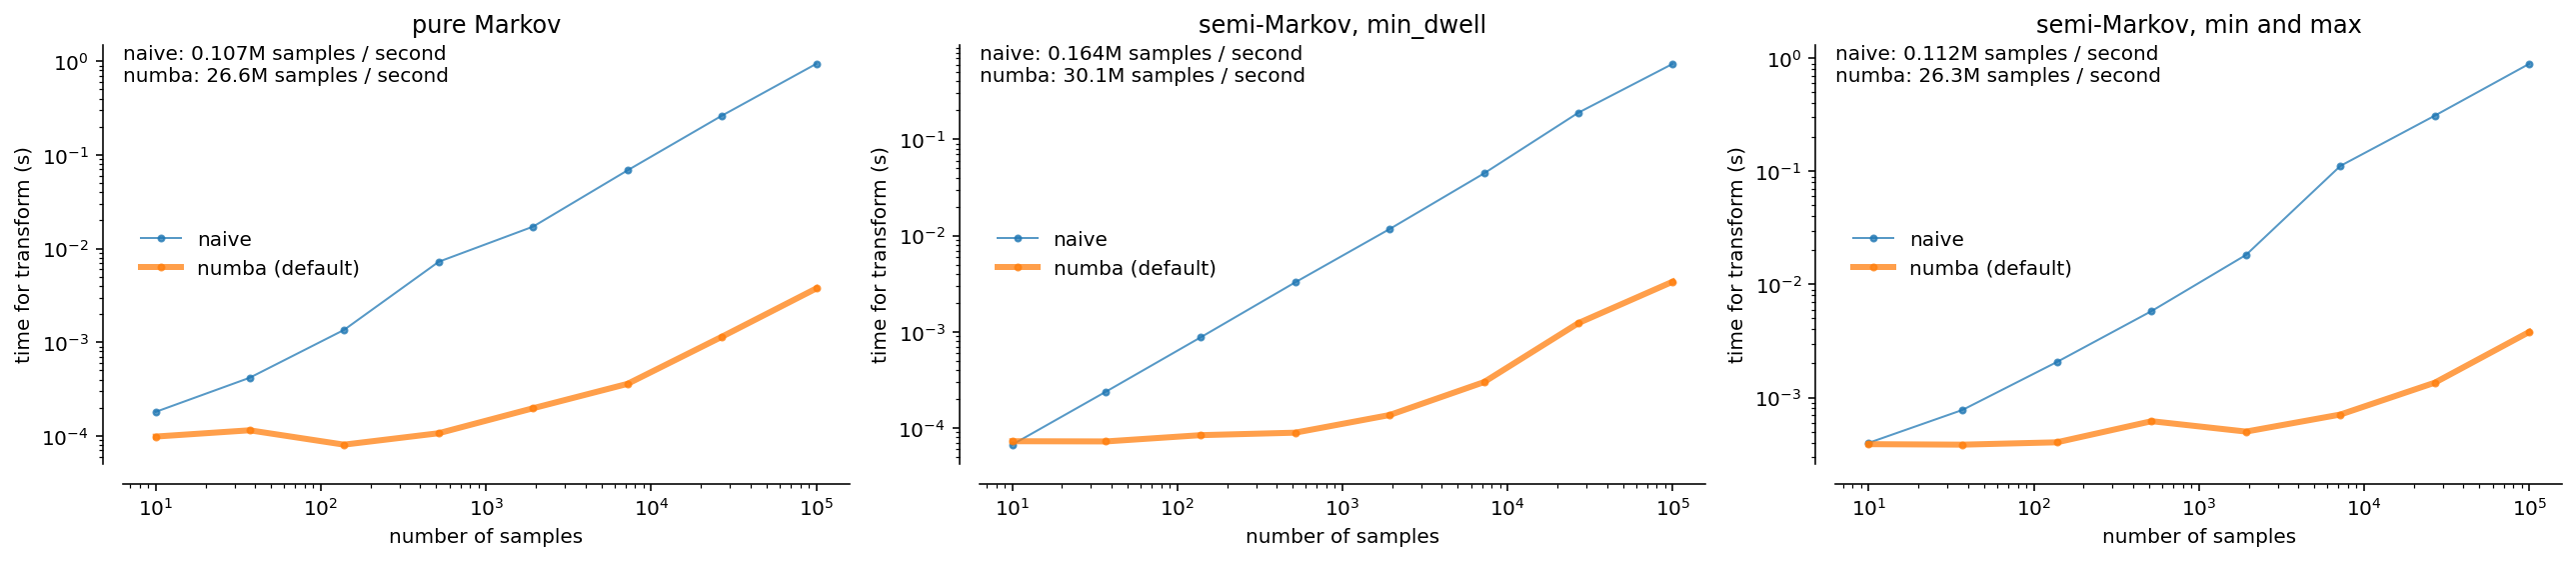

In [18]:
default_mode = SemiMarkov(2)._mode

with FigureManager(1, len(speed_test.args)) as (_, axs):
    for i, ax in enumerate(axs):
        crt_rates = []
        crt_annot_list = []
        crt_args_name = list(speed_test.args.keys())[i]
        for crt_mode in speed_test.all_modes:
            crt_results = speed_test.results[crt_mode, crt_args_name]
            is_default = crt_mode == default_mode
            if not is_default:
                crt_mode_label = crt_mode
            else:
                crt_mode_label = crt_mode + " (default)"
                
            ax.loglog(
                crt_results["sizes"],
                crt_results["times"],
                ".-",
                label=crt_mode_label,
                alpha=0.75,
                lw=3 if is_default else 1,
            )

            crt_rate = crt_results["sizes"][-1] / crt_results["times"][-1] / 1000000
            crt_rates.append(crt_rate)
            crt_annot_list.append(f"{crt_mode}: {crt_rate:.3g}M samples / second")

        ax.set_title(crt_args_name)
        ax.legend(frameon=False, loc="center left")

        ax.set_xlabel("number of samples")
        ax.set_ylabel("time for transform (s)")

        crt_annot = "\n".join(crt_annot_list)
        ax.annotate(
            crt_annot, (0.0, 1.0), xycoords="axes fraction", verticalalignment="top"
        )